# Own Model Using Transformer Encoder

In [5]:
import numpy as np
import pandas as pd

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/"

In [55]:
data = pd.read_json(f"{BASE_DIR}/data/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data_2 = pd.read_json(f"{BASE_DIR}/data/Sarcasm_Headlines_Dataset.json", lines=True)

In [58]:
data = pd.concat([data[["headline", "is_sarcastic"]], data_2[["headline", "is_sarcastic"]]])
data = data.reset_index(drop=True)
# data = data.drop(["article_link"], axis=1)
data.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


# Text preprocessing

In [59]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [61]:
stop_words = stopwords.words("english") + ["u", "im", "c"]

def process(x: str) -> str:
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemma.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = " ".join(headline)

    return headline

In [62]:
process(data["headline"][4])

'mother come pretty close use word stream correctly'

In [63]:
data['clean_headline'] = data['headline'].apply(process)

In [64]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data.head()

,headline,is_sarcastic,clean_headline,sentence_length
0,thirtysomething scientists unveil doomsday clo...,1,thirtysomething scientists unveil doomsday clo...,7
1,dem rep. totally nails why congress is falling...,0,dem rep totally nail congress fall short gende...,10
2,eat your veggies: 9 deliciously different recipes,0,eat veggies 9 deliciously different recipes,6
3,inclement weather prevents liar from getting t...,1,inclement weather prevent liar get work,6
4,mother comes pretty close to using word 'strea...,1,mother come pretty close use word stream corre...,8


In [65]:
data = data.drop(data["sentence_length"].idxmax())

# Model Building

In [66]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [67]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test Splitting (80:10:10)

In [68]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenization
- Splitting sentences into words
- Finding the vocab size

In [69]:
max_len = 20
oov_token = '00_V'
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20883


## Encoding of Inputs
- Converting the sentences to token followed by padded sequences in encoded format
- These are numeric encodings assigned to each word

In [70]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Multi-Head Attention

In [71]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Model

In [72]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddi  (None, 20, 50)            1045300   
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder_1 (Tra  (None, 20, 50)            23832     
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_1  (None, 50)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 50)                0   

## Model Training

In [74]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [75]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
1384/1384 [==============================] - 40s 26ms/step - loss: 0.4677 - accuracy: 0.7672 - val_loss: 0.3274 - val_accuracy: 0.8641
Epoch 2/25
1384/1384 [==============================] - 41s 29ms/step - loss: 0.2512 - accuracy: 0.8995 - val_loss: 0.2922 - val_accuracy: 0.8863
Epoch 3/25
1384/1384 [==============================] - 37s 27ms/step - loss: 0.1729 - accuracy: 0.9354 - val_loss: 0.2670 - val_accuracy: 0.9019
Epoch 4/25
1384/1384 [==============================] - 43s 31ms/step - loss: 0.1272 - accuracy: 0.9542 - val_loss: 0.2694 - val_accuracy: 0.9167
Epoch 4: early stopping


# Model Evaluation Metrics

In [79]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')



def plot_results(model_history):
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [87]:
# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

173/173 [==============================] - 2s 11ms/step - loss: 0.2491 - accuracy: 0.9210
Test Accuracy: 0.9210193157196045


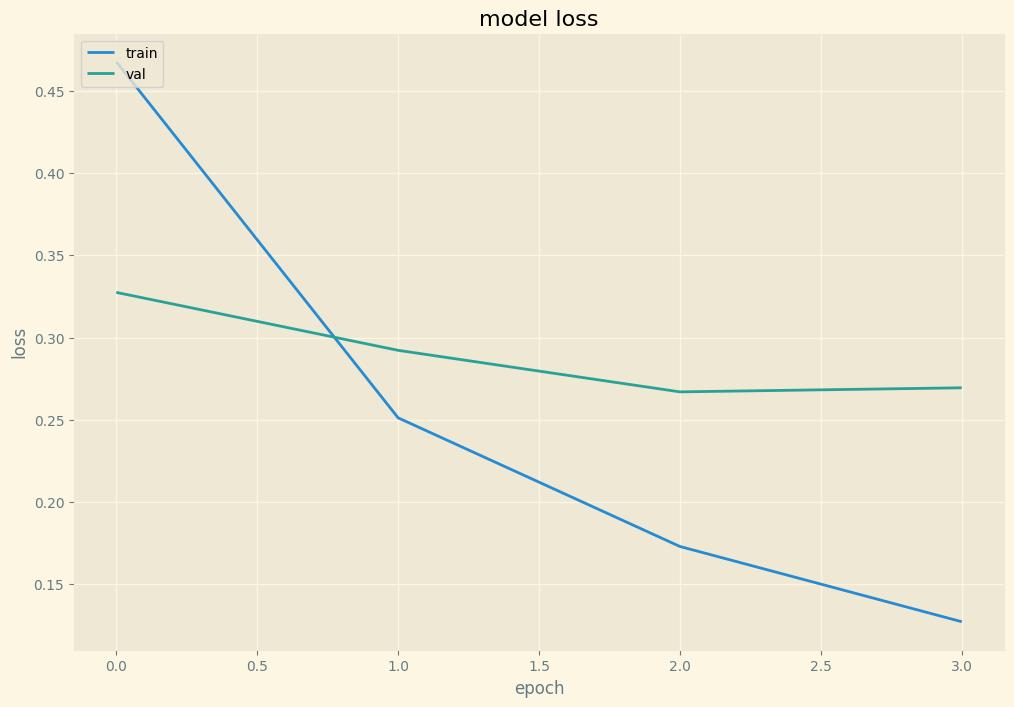

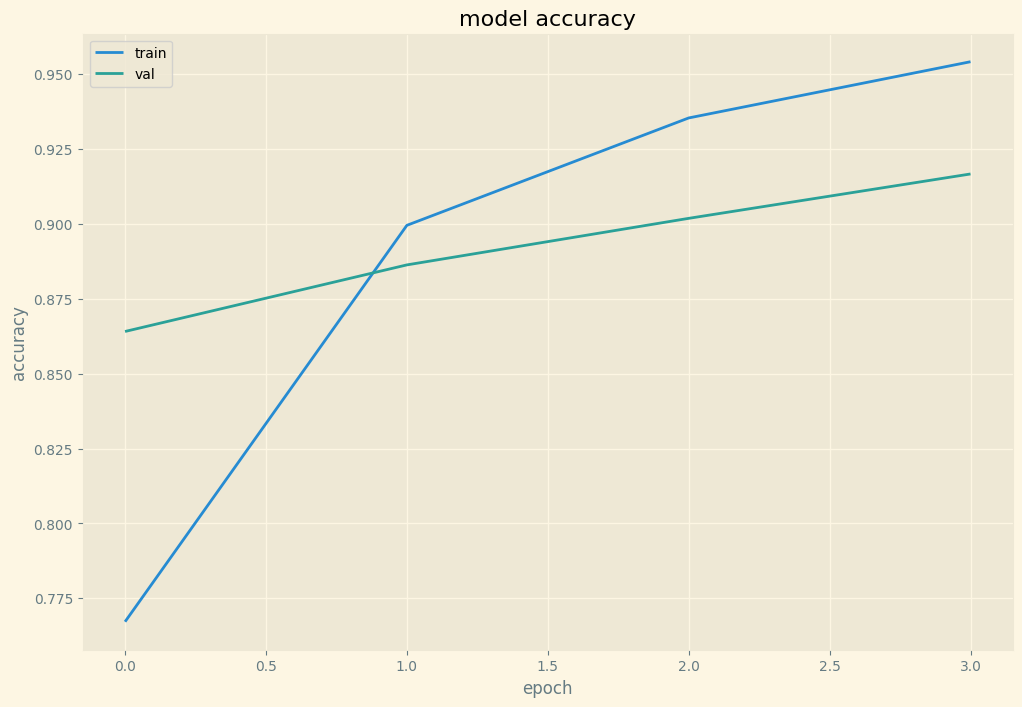

In [80]:
plot_results(history)

In case of overfitting we can use:
- Low learning rate
- L1-L2 Regularization
- Dropout
- Lesser Neurons in MLP layers
- Early Stopping
- etc.

# Classification Metrics

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### ROC Curve

173/173 [==============================] - 1s 5ms/step


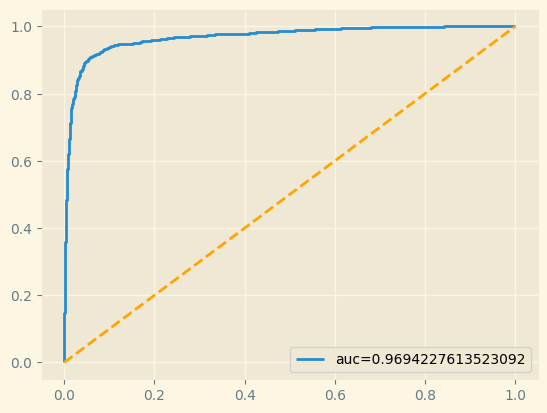

In [84]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

# classification_report

In [85]:
y_pred[y_pred >= 0.85] = 1
y_pred[y_pred < 0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2997
           1       0.95      0.87      0.91      2536

    accuracy                           0.92      5533
   macro avg       0.92      0.92      0.92      5533
weighted avg       0.92      0.92      0.92      5533



# confusion_matrix

<Axes: >

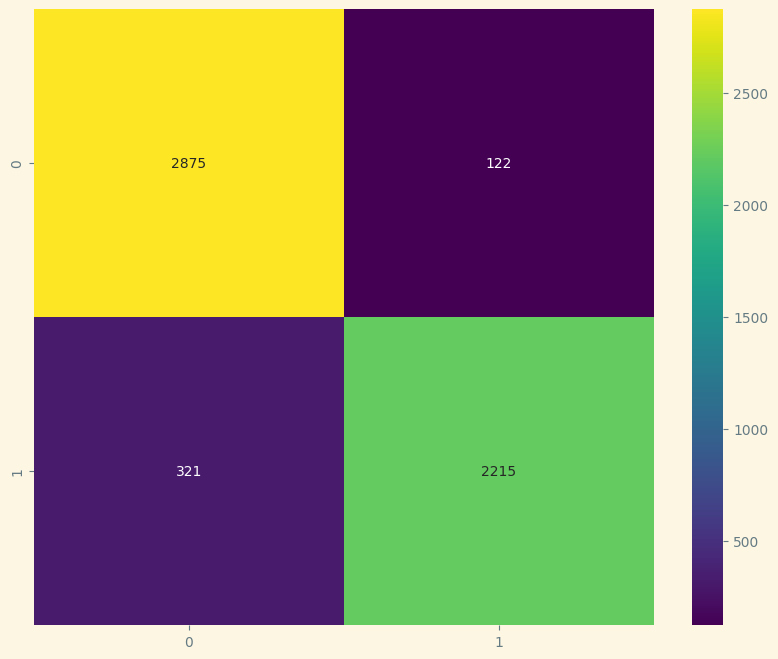

In [86]:
plt.figure(figsize=(10,8))
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')